Imports

In [53]:
import tensorflow as tf
import numpy as np
tf.random.set_seed(89)
np.random.seed(89)

from tensorflow import keras
from tensorflow.keras.layers import Activation, Dense, Conv2D, MaxPool2D, Dropout, BatchNormalization, Flatten
from tensorflow.keras.metrics import CategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import itertools

import datetime
%matplotlib inline

In [2]:
train_path = '/content/drive/MyDrive/Pneumonia/train'
test_path = '/content/drive/MyDrive/Pneumonia/test'
aug_path = '/content/drive/MyDrive/Pneumonia/train/NORMAL'

ImageDataGenerator to generate augmented images for 'NORMAL' class

In [8]:
# aug_gen = ImageDataGenerator(
#                             #  width_shift_range=(-0.1, 0.1),
#                             #  height_shift_range=(-0.1, 0.1),
#                             #  rotation_range=15,
#                              horizontal_flip=True
#                              )

# aug_iter = aug_gen.flow_from_directory(directory=train_path, shuffle=False, classes=['NORMAL'],
#                                        save_to_dir=aug_path, save_prefix='aug-image-', save_format='jpeg'
#                                        )

Found 3444 images belonging to 1 classes.


In [9]:
# for i in range(25):
#   next(aug_iter)[0]


Create training, validation and test batches

In [3]:
imgen = ImageDataGenerator(preprocessing_function=preprocess_input,
                           validation_split=0.2
                           )

In [4]:
train_batches = imgen.flow_from_directory(directory=train_path,
                          target_size=(224,224),
                          color_mode='rgb',
                          classes=['NORMAL', 'PNEUMONIA'],
                          batch_size=32,
                          subset='training',
                          shuffle=True,
                          seed=89)

valid_batches = imgen.flow_from_directory(directory=train_path,
                          target_size=(224,224),
                          color_mode='rgb',
                          classes=['NORMAL', 'PNEUMONIA'],
                          batch_size=32,
                          subset='validation',
                          shuffle=True,
                          seed=89)

test_batches = imgen.flow_from_directory(directory=test_path,
                                         target_size=(224,224),
                                         color_mode='rgb',
                                         classes=['NORMAL', 'PNEUMONIA'],
                                         batch_size=32,
                                         shuffle=False)


Found 5863 images belonging to 2 classes.
Found 1464 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


Instantiate MobileNet v2

In [61]:
mobile = MobileNetV2()
len(mobile.layers)

157

Build functional model using majority of layers from the 157 available and add a dense output layer with two units corresponding to our two classes

In [62]:
x = mobile.layers[-6].output
x = Conv2D(filters=32, activation='relu', kernel_size=(3,3), strides=(2,2))(x)
x = Dropout(rate=0.1)(x)
x = BatchNormalization()(x)
x = Flatten()(x)
output = Dense(units=2, activation='softmax')(x)
model = tf.keras.Model(inputs=mobile.input, outputs=output)

Determine which layers are trainable or not

In [63]:
for layer in model.layers[:-10]:
  layer.trainable = False


Compile the model with Adam optimizer and accuracy metrics

In [64]:
model.compile(optimizer=Adam(learning_rate=0.006), metrics=['accuracy'], loss='categorical_crossentropy')
model.summary()

Model: "functional_13"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_5[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
______________________________________________________________________________________

In [65]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',
                                                  patience=3)

In [66]:
import datetime
suffix = datetime.datetime.now().strftime('%b%m%y-%H%M')

model.fit(x=train_batches,
          batch_size=32,
          validation_data=valid_batches,
          validation_steps=len(valid_batches),
          shuffle=False,
          epochs=10,
          steps_per_epoch=len(train_batches),
          verbose=2
          
          # callbacks=[early_stopping]
          )
# 10 best so far, lr = 0.0005, 10 epochs gave 88% 
# Do 10 with lr 001 next

model.save(f'/content/drive/MyDrive/Pneumonia/models/mnv2-{suffix}.h5')

Epoch 1/10
184/184 - 68s - loss: 0.0990 - accuracy: 0.9649 - val_loss: 1.3686 - val_accuracy: 0.7480
Epoch 2/10
184/184 - 65s - loss: 0.0413 - accuracy: 0.9841 - val_loss: 0.2344 - val_accuracy: 0.9385
Epoch 3/10
184/184 - 65s - loss: 0.0266 - accuracy: 0.9904 - val_loss: 0.3674 - val_accuracy: 0.8955
Epoch 4/10
184/184 - 65s - loss: 0.0239 - accuracy: 0.9908 - val_loss: 0.0991 - val_accuracy: 0.9720
Epoch 5/10
184/184 - 64s - loss: 0.0118 - accuracy: 0.9961 - val_loss: 0.1123 - val_accuracy: 0.9686
Epoch 6/10
184/184 - 63s - loss: 0.0053 - accuracy: 0.9980 - val_loss: 0.0863 - val_accuracy: 0.9740
Epoch 7/10
184/184 - 63s - loss: 0.0026 - accuracy: 0.9990 - val_loss: 0.0612 - val_accuracy: 0.9843
Epoch 8/10
184/184 - 63s - loss: 0.0190 - accuracy: 0.9935 - val_loss: 0.1658 - val_accuracy: 0.9693
Epoch 9/10
184/184 - 64s - loss: 0.0126 - accuracy: 0.9961 - val_loss: 0.0624 - val_accuracy: 0.9816
Epoch 10/10
184/184 - 63s - loss: 0.0062 - accuracy: 0.9974 - val_loss: 0.0702 - val_accura

In [67]:
model.evaluate(x=test_batches, steps=len(test_batches))

20/20 [==============================] - 6s 310ms/step - loss: 0.6868 - accuracy: 0.8878


[0.6867592930793762, 0.8878205418586731]

In [68]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[172  62]
 [  8 382]]


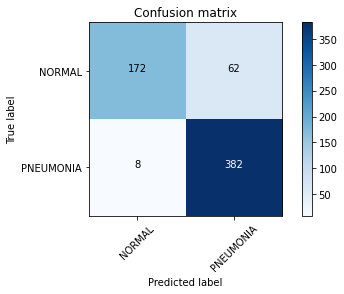

In [69]:
predictions = model.predict(x=test_batches, steps=len(test_batches))
test_labels = test_batches.classes
cm = confusion_matrix(y_true=test_labels, y_pred=predictions.argmax(axis=1))
plot_confusion_matrix(cm=cm, classes=['NORMAL', 'PNEUMONIA'])